In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

# A/B Testing: Theory Behind the Notebook

This notebook implements a **two-sample A/B test for conversion rates**.
The goal is to determine whether a change (Treatment) leads to a **real, statistically detectable improvement**
over the current experience (Control).

---

## What problem are we solving?

Each user either:

- converts (1)
- or does not convert (0)

So each conversion follows a **Bernoulli distribution**, and the conversion rate is a **probability**.

We want to answer:

> Is the observed difference in conversion rates real,  
> or could it be explained by random variation?

---

## Step 1: Define the baseline and the effect we care about



In [9]:
# Assume control group probability and treatment group's probability
p_control = 0.10
mde = 0.05
p_treatment = p_control + mde

# Baseline conversion rate: 10%
# Minimum Detectable Effect (MDE): +5 percentage points
# Target treatment rate: 15%
# In real conversions, your baseline can be around 4%, and MDE is about 0.5%, my experiment was set larger to see the outcomes clearly

#### Why MDE matters

We are not asking:

> Can I detect any difference?

We are asking:

> Can I reliably detect a difference that is worth acting on?

Smaller effects require much larger samples.
The MDE defines what “worth detecting” means from a business perspective.

In [10]:
alpha = 0.05
power = 0.80

These values define how risky our decision process is.

## Type I error (α)

- **Probability of false positive**
- Rejecting \(H_0\) when there is actually no difference
- Common choice: **5%**

## Type II error (β) and power

- **β**: probability of missing a real effect
- **Power** = \(1 - \beta\)

**Power = 80% means:**
- If the true lift is at least the MDE,
- We will detect it **8 times out of 10**


In [11]:
z_alpha = stats.norm.ppf(1 - alpha / 2)
z_beta = stats.norm.ppf(power)

## Why z-values?

- Sampling distributions of proportions become approximately normal (CLT)
- Decisions are made in standardized (z) space

### Interpretation

- **\(z_alpha\)**: how extreme a result must be to be called *statistically significant*
- **\(z_beta\)**: how far apart the distributions must be to achieve desired power

These values are fixed once **α** and **power** are chosen.


In [12]:
p_bar = (p_control + p_treatment) / 2


n_per_group = (
(z_alpha * np.sqrt(2 * p_bar * (1 - p_bar)) +
z_beta * np.sqrt(p_control * (1 - p_control) + p_treatment * (1 - p_treatment))) ** 2
/ (p_treatment - p_control) ** 2
)


n_per_group = int(np.ceil(n_per_group))
print(n_per_group)

686


## This formula answers:

**How many users do we need per group so that:**

- Random noise is small enough
- A lift of size MDE crosses the critical z-boundary
- With probability = power

### Key intuition

- Smaller MDE → larger sample
- Higher power → larger sample
- Lower α → larger sample

**Note:** Sample size is not arbitrary — it is dictated by **risk tolerance** and **effect size**.


In [13]:
users = pd.DataFrame({
    "user_id": range(2 * n_per_group)
})

users["group"] = np.random.choice(["control", "treatment"], size=len(users))

users.head()

,user_id,group
0,0,control
1,1,treatment
2,2,control
3,3,control
4,4,control


##### Randomization ensures groups are statistically comparable

In [18]:
# Simulating user behaviour
users["conversion"] = np.where(
    users["group"] == "control",
    np.random.binomial(1, p_control, size=len(users)),
    np.random.binomial(1, p_treatment, size=len(users))
)

users.head()

,user_id,group,conversion
0,0,control,0
1,1,treatment,0
2,2,control,0
3,3,control,0
4,4,control,0


In [19]:
summary = users.groupby("group")["conversion"].agg(["mean", "count", "sum"])
summary.rename(columns={"mean": "conversion_rate"}, inplace=True)
summary

,conversion_rate,count,sum
group,,,
control,0.113537,687,78
treatment,0.134307,685,92


**Each user represents a Bernoulli trial, total conversions is Binomial Distribution:**

- Probability of success = conversion rate

- This matches the real-world traffic data collection process

In [20]:
# Hypothesis formulation
# H0: p_control = p_treatment
# H1: p_control != p_treatment (two-sided test)

conv_control = summary.loc["control", "sum"]
n_control = summary.loc["control", "count"]

conv_treat = summary.loc["treatment", "sum"]
n_treat = summary.loc["treatment", "count"]

#This is a two-sided test, assume we care about both increases and decreases

In [21]:
# Statistical test: two-proportion z-test

p_pool = (conv_control + conv_treat) / (n_control + n_treat)

se = np.sqrt(p_pool * (1 - p_pool) * (1 / n_control + 1 / n_treat))

z_stat = (conv_treat / n_treat - conv_control / n_control) / se
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"Z-statistic: {z_stat:.3f}")
print(f"p-value: {p_value:.4f}")

Z-statistic: 1.167
p-value: 0.2430


## The p-value

- The p-value is computed under the **null hypothesis**
- It represents how extreme the result would be if there were no real difference

### Decision

- If \(p\_value < alpha\): **reject \(H_0\)**
- Otherwise: **insufficient evidence**

### Important

- “Fail to reject” ≠ “no effect”
- It means there is **not enough evidence** given the sample size


In [22]:
# Decision
if p_value < alpha:
    print("Reject H0: statistically significant difference")
else:
    print("Fail to reject H0: no statistically significant difference")

Fail to reject H0: no statistically significant difference


In [23]:
# Confidence interval for lift

diff = conv_treat / n_treat - conv_control / n_control
ci_low = diff - z_alpha * se
ci_high = diff + z_alpha * se

print(f"Estimated lift: {diff:.4f}")
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")

Estimated lift: 0.0208
95% CI: [-0.0141, 0.0556]


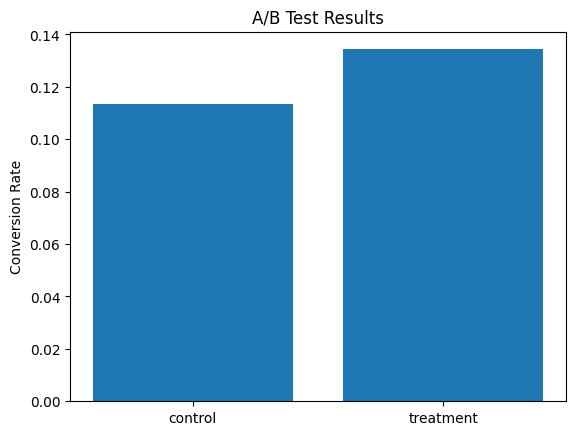

In [24]:
#  Visualization

plt.bar(summary.index, summary["conversion_rate"])
plt.ylabel("Conversion Rate")
plt.title("A/B Test Results")
plt.show()

### If we want to only focus on growth in conversion rates, then we should apply one sided test

In [25]:
# Pooled proportion (same as two-sided)
p_pool = (conv_control + conv_treat) / (n_control + n_treat)

# Standard error for difference in proportions
se = np.sqrt(p_pool * (1 - p_pool) * (1 / n_control + 1 / n_treat))

# z-statistic
z_stat = (conv_treat / n_treat - conv_control / n_control) / se

# One-sided p-value (treatment > control)
p_value = 1 - stats.norm.cdf(z_stat)

print(f"Z-statistic: {z_stat:.3f}")
print(f"One-sided p-value: {p_value:.4f}")

# Decision
alpha = 0.05
if p_value < alpha:
    print("Reject H0: treatment is significantly higher than control")
else:
    print("Fail to reject H0: not enough evidence that treatment is higher")


Z-statistic: 1.167
One-sided p-value: 0.1215
Fail to reject H0: not enough evidence that treatment is higher


In [33]:
ci_lower = (conv_treat / n_treat - conv_control / n_control) - z_alpha * se
ci_upper = np.inf  # one-sided


print(f"Estimated lift: {diff:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")

Estimated lift: 0.0208
95% CI: [-0.0141, inf]


## Here I want to show you how are H0, H1, z values, CI, alpha and betta are represented on the graph

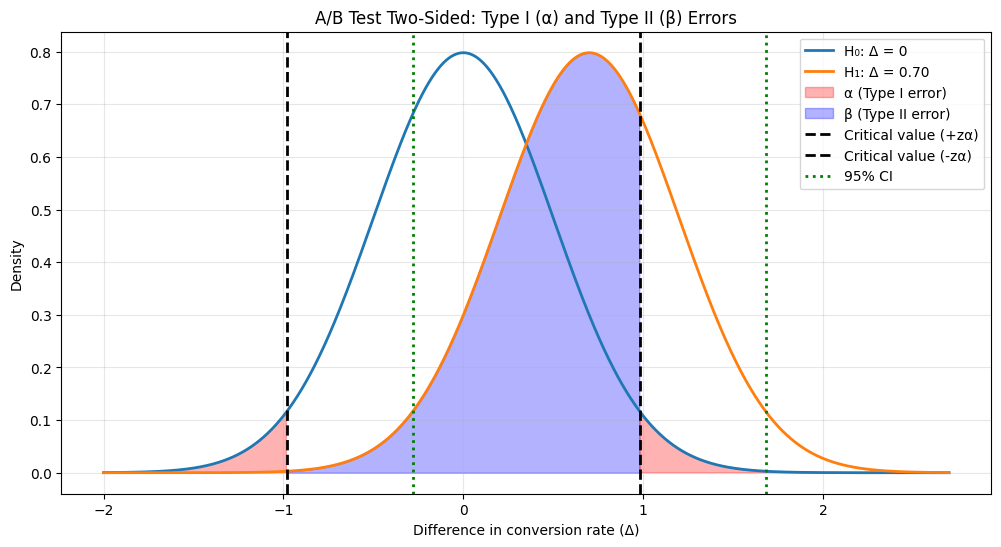

In [36]:
from scipy.stats import norm

# Experiment parameters are bigger to see the distinguishable changes in alpha and betta 

p_control = 0.10
mde = 0.7 # exaggerated for visualization
p_treatment = p_control + mde

alpha = 0.05

# Standard error of difference
se_diff = np.sqrt(p_control*(1-p_control) + p_treatment*(1-p_treatment))

# Critical values for two-sided test
z_alpha = norm.ppf(1 - alpha/2)
critical_upper = 0 + z_alpha * se_diff
critical_lower = 0 - z_alpha * se_diff

# H0 and H1 means (difference in conversion rate)
mu0 = 0
mu1 = p_treatment - p_control

# Set x-axis wide enough to cover both distributions
x_min = min(mu0 - 4*se_diff, mu1 - 4*se_diff)
x_max = max(mu0 + 4*se_diff, mu1 + 4*se_diff)
x = np.linspace(x_min, x_max, 1000)

# PDFs
pdf_h0 = norm.pdf(x, mu0, se_diff)
pdf_h1 = norm.pdf(x, mu1, se_diff)

plt.figure(figsize=(12,6))

# Plot distributions
plt.plot(x, pdf_h0, label="H₀: Δ = 0", linewidth=2)
plt.plot(x, pdf_h1, label=f"H₁: Δ = {mde:.2f}", linewidth=2)

# Shade alpha region under H0 (both tails)
plt.fill_between(x, pdf_h0, where=(x <= critical_lower) | (x >= critical_upper),
                 color='red', alpha=0.3, label='α (Type I error)')

# Shade beta region under H1 (non-rejection region)
plt.fill_between(x, pdf_h1, where=(x >= critical_lower) & (x <= critical_upper),
                 color='blue', alpha=0.3, label='β (Type II error)')

# Critical value lines
plt.axvline(critical_upper, linestyle='--', color='black', linewidth=2, label='Critical value (+zα)')
plt.axvline(critical_lower, linestyle='--', color='black', linewidth=2, label='Critical value (-zα)')

# Confidence interval for observed lift (for illustration)
ci_low = mu1 - z_alpha * se_diff
ci_high = mu1 + z_alpha * se_diff
plt.axvline(ci_low, color='green', linestyle=':', linewidth=2, label='95% CI')
plt.axvline(ci_high, color='green', linestyle=':', linewidth=2)

# Labels
plt.xlabel("Difference in conversion rate (Δ)")
plt.ylabel("Density")
plt.title("A/B Test Two-Sided: Type I (α) and Type II (β) Errors")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


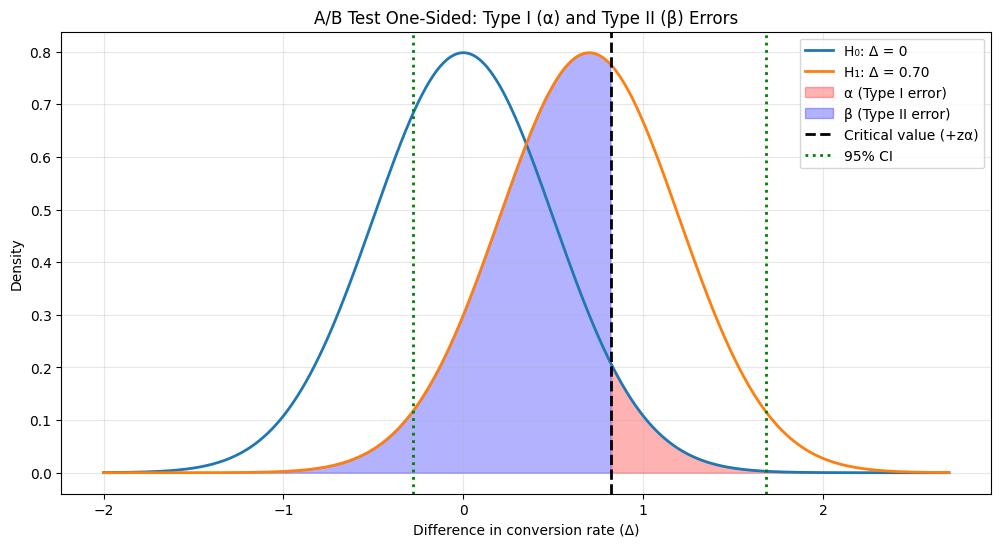

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ==============================
# Experiment parameters
# ==============================
p_control = 0.10
mde = 0.7   # exaggerated for visualization
p_treatment = p_control + mde

alpha = 0.05

# Standard error of difference
se_diff = np.sqrt(p_control*(1-p_control) + p_treatment*(1-p_treatment))

# Critical value for one-sided test (upper tail)
z_alpha = norm.ppf(1 - alpha)
critical_value = 0 + z_alpha * se_diff

# H0 and H1 means (difference in conversion rate)
mu0 = 0
mu1 = p_treatment - p_control

# Set x-axis wide enough to cover both distributions
x_min = min(mu0 - 4*se_diff, mu1 - 4*se_diff)
x_max = max(mu0 + 4*se_diff, mu1 + 4*se_diff)
x = np.linspace(x_min, x_max, 1000)

# PDFs
pdf_h0 = norm.pdf(x, mu0, se_diff)
pdf_h1 = norm.pdf(x, mu1, se_diff)

plt.figure(figsize=(12,6))

# Plot distributions
plt.plot(x, pdf_h0, label="H₀: Δ = 0", linewidth=2)
plt.plot(x, pdf_h1, label=f"H₁: Δ = {mde:.2f}", linewidth=2)

# Shade alpha region under H0 (one-sided, upper tail only)
plt.fill_between(x, pdf_h0, where=(x >= critical_value),
                 color='red', alpha=0.3, label='α (Type I error)')

# Shade beta region under H1 (non-rejection region)
plt.fill_between(x, pdf_h1, where=(x <= critical_value),
                 color='blue', alpha=0.3, label='β (Type II error)')

# Critical value line
plt.axvline(critical_value, linestyle='--', color='black', linewidth=2, label='Critical value (+zα)')

# Confidence interval for observed lift (illustrative)
ci_low = mu1 - norm.ppf(1 - alpha/2) * se_diff  # still 95% CI two-sided for demonstration
ci_high = mu1 + norm.ppf(1 - alpha/2) * se_diff
plt.axvline(ci_low, color='green', linestyle=':', linewidth=2, label='95% CI')
plt.axvline(ci_high, color='green', linestyle=':', linewidth=2)

# Labels
plt.xlabel("Difference in conversion rate (Δ)")
plt.ylabel("Density")
plt.title("A/B Test One-Sided: Type I (α) and Type II (β) Errors")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Statistical Formulas

## 1. Data generating process

Each user conversion is a Bernoulli random variable.

$$
X_i \sim \text{Bernoulli}(p)
$$

Total conversions in a group:

$$
X \sim \text{Binomial}(n, p)
$$

Estimated conversion rate:

$$
\hat{p} = \frac{X}{n}
$$

---

## 2. Normal approximation (CLT)

For large $n$:

$$
\hat{p} \approx \mathcal{N}
\left(
p,\;
\frac{p(1-p)}{n}
\right)
$$

---

## 3. Hypotheses

$$
H_0: p_c = p_t
$$

$$
H_1: p_c \neq p_t
$$

---

## 4. Significance level and power

Type I error:

$$
\alpha = P(\text{reject } H_0 \mid H_0 \text{ true})
$$

Power:

$$
1 - \beta = P(\text{reject } H_0 \mid H_1 \text{ true})
$$

Normal quantiles:

$$
z_\alpha = \Phi^{-1}\left(1 - \frac{\alpha}{2}\right)
$$

$$
z_\beta = \Phi^{-1}(1 - \beta)
$$

---

## 5. Pooled probability

$$
\bar{p} = \frac{p_c + p_t}{2}
$$

---

## 6. Sample size per group

$$
n =
\frac{
\left[
z_\alpha \sqrt{2 \bar{p}(1 - \bar{p})}
+
z_\beta \sqrt{p_c(1 - p_c) + p_t(1 - p_t)}
\right]^2
}
{(p_t - p_c)^2}
$$

Final sample size:

$$
n_{\text{final}} = \lceil n \rceil
$$

---

## 7. Two-proportion z-test

Pooled estimate:

$$
\hat{p}_{\text{pool}} =
\frac{x_c + x_t}{n_c + n_t}
$$

Standard error:

$$
SE =
\sqrt{
\hat{p}_{\text{pool}}(1 - \hat{p}_{\text{pool}})
\left(
\frac{1}{n_c} + \frac{1}{n_t}
\right)
}
$$

Z-statistic:

$$
z =
\frac{\hat{p}_t - \hat{p}_c}{SE}
$$

---

## 8. p-value

$$
p\text{-value} =
2 \left(1 - \Phi(|z|)\right)
$$

Decision rule:

$$
\text{Reject } H_0 \quad \text{if} \quad p\text{-value} < \alpha
$$

---

## 9. Confidence interval for lift

Estimated lift:

$$
\Delta = \hat{p}_t - \hat{p}_c
$$

Confidence interval:

$$
\Delta \pm z_\alpha \cdot SE
$$

---

## 10. Normal approximation validity

$$
np > 5
\quad \text{and} \quad
n(1 - p) > 5
$$


## Things to experiment with
- Change p_control or mde
- Lower the MDE and see how sample size explodes
- Switch to one-sided test (product wants only improvement)
- Stop the test early and observe false positives
